In [1]:
import os
import sys
import pathlib

import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import torchvision
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt 
import albumentations as albu

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

# Fix to be able to import python modules inside a notebook
os.chdir('..')

# Useful extensions
# %load_ext watermark
# %watermark -v -n -m -p numpy,torch,albumentations,photosynthesis_metrics

# %load_ext autoreload
# %autoreload 2

# Nice plot formating
%matplotlib inline

In [3]:
import os
import time
import math
import yaml
import argparse
from pathlib import Path

import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
# import pytorch_tools as pt
from loguru import logger

from src.datasets import get_val_dataloader, get_test_dataloader
from src.callbacks import cmc_score_count, map_at_k, accuracy_at_1
from src.models import Model, kNN

In [4]:
!ls

configs  Makefile    preprocess.py  requirements.txt  train.py
data	 notebooks   __pycache__    src
logs	 predict.py  README.md	    tmp.txt


# Validation

In [39]:
def map_at_k_2(perm_matrix: torch.Tensor, conformity_matrix: torch.Tensor, topk: int = 10) -> float:
    """Compute mean Average Precision (mAP@k) from distance matrix and conformity matrix.
    If topk parameter is None, returns mAP@R, see [1] for details.

    Args:
        perm_matrix: Permutation matrix shape of (n_embeddings_x, n_embeddings_y)
        conformity_matrix: binary matrix with 1 on same label pos
            and 0 otherwise
        topk: number of top examples for AP counting.

    Returns:
        mAP@k score

    Reference:
        [1] A Metric Learning Reality Check
            https://arxiv.org/pdf/2003.08505.pdf
    """
    conformity_matrix = conformity_matrix.type(torch.double)

    if topk is None:  # Compute mAP@R
        # Total total number of references that are the same class as the query.
        R = conformity_matrix.sum(dim=1)
        R_max = int(R.max())
    else:  # Compute mAP@k
        R = torch.ones(perm_matrix.size(0)) * topk
        R_max = topk
    R_max = min(R_max, perm_matrix.shape[1])

    R_mask = torch.cumsum(torch.ones(
        (perm_matrix.size(0), R_max)), dim=1) <= R.reshape(-1, 1)

    # Sort matrix
    conformity_matrix = torch.gather(conformity_matrix, 1, perm_matrix)[
        :, :R_max] * R_mask
    precision = torch.cumsum(conformity_matrix, dim=-1) * conformity_matrix \
        / torch.arange(start=1, end=R_max + 1)
    average_precision = precision.sum(dim=-1) / conformity_matrix.sum(dim=-1)

    # If no match found at first k elements, AP is 0
    average_precision[average_precision.isnan()] = 0
    return average_precision # .mean().item()

In [40]:
# Best model genet_normal_384_hard_arcface80_15

# Get model
model = Model(
    arch="genet_normal",
    model_params={},
    embedding_size=512,
    pooling='gem').cuda()
# logger.info(model)

# Init
config_path = pathlib.Path("logs/genet_normal_384_hard_arcface80_15/")

checkpoint = torch.load(config_path / f"model.chpn")
model.load_state_dict(checkpoint["state_dict"], strict=True)

data = np.load(config_path / "val_embeddings.npy", allow_pickle=True)
val_embeddings = torch.tensor(data.item()["embeddings"])
indexes = data.item()["indexes"]

# Load validation query / gallery split and sort it according to indexes from sampler
df_val = pd.read_csv(os.path.join("data/interim", "train_val.csv"))
print(len(df_val[df_val["is_train"].astype(np.bool) == False]), len(indexes))
df_val = df_val[df_val["is_train"].astype(np.bool) == False].iloc[indexes]

query_mask = df_val["is_query"].values.astype(np.bool)
val_labels = df_val["label"].values

# Shape (n_embeddings, embedding_dim)
query_embeddings, gallery_embeddings = val_embeddings[query_mask], val_embeddings[~query_mask]
query_files, gallery_files = df_val["full_path"].values[query_mask], df_val["full_path"].values[~query_mask]
query_labels, gallery_labels = val_labels[query_mask], val_labels[~query_mask]
logger.info(f"Validation query size - {len(query_embeddings)}, gallery size - {len(gallery_embeddings)}")
del val_embeddings

2020-09-29 19:54:58.204 | INFO     | __main__:<module>:33 - Validation query size - 1700, gallery size - 21971


23671 23671


In [41]:
from predict import query_expansion

In [42]:
dba = False
aqe = False
num_iter = 3

if dba:
    for _ in range(num_iter):
        gallery_embeddings = query_expansion(gallery_embeddings, gallery_embeddings, topk=5, alpha=3)

if aqe:
    for _ in range(num_iter):
        query_embeddings = query_expansion(query_embeddings, gallery_embeddings, topk=2, alpha=3)

# Shape (query_size x gallery_size)
conformity_matrix = torch.tensor(query_labels.reshape(-1, 1) == gallery_labels)

# Init kNN and find neighbours
knn = kNN(embeddings=gallery_embeddings, distance='cosine')
# Get distance matrix of shape (query_length x 1000)
distances, perm_matrix = knn.search(query_embeddings, topk=200)

# Compute validation metrics
# acc1 = cmc_score_count(perm_matrix, conformity_matrix, topk=1)
acc1 = accuracy_at_1(perm_matrix, conformity_matrix)
# map10 = map_at_k(perm_matrix, conformity_matrix, topk=10)
# mapR = map_at_k(perm_matrix, conformity_matrix, topk=None)
map10 = map_at_k_2(perm_matrix, conformity_matrix, topk=10)
mapR = map_at_k_2(perm_matrix, conformity_matrix, topk=None)

# logger.info(
#     f"Val: Acc@1 {acc1:0.5f}, mAP@10 {map10:0.5f}, Target {0.5 * acc1 + 0.5 * map10:0.5f}, mAP@R {mapR:0.5f}") 

In [46]:
map10.mean()

tensor(0.9608, dtype=torch.float64)

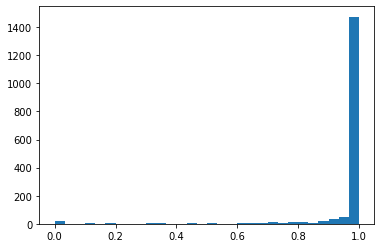

In [49]:
plt.hist(map10, bins=30);

In [51]:
mapR.eq(1).sum()

tensor(1069)

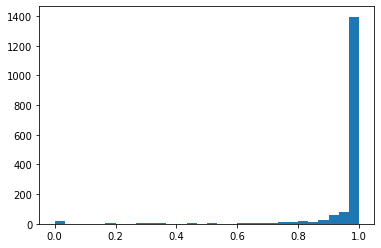

In [50]:
plt.hist(mapR, bins=30);

In [10]:
topk=30
reranked = rerank(query_files, gallery_files, perm_matrix, topk=topk, limit=25)

NameError: name 'rerank' is not defined

In [28]:
reranked = torch.tensor(reranked)
print(reranked.shape)

torch.Size([1700, 2])


In [11]:
# Compute validation metrics
# acc1 = cmc_score_count(perm_matrix, conformity_matrix, topk=1)
acc1 = accuracy_at_1(reranked, conformity_matrix)
# map10 = map_at_k(reranked, conformity_matrix, topk=10)
# mapR = map_at_k(reranked, conformity_matrix, topk=None)

logger.info(
    f"Val: Acc@1 {acc1:0.5f}") 

NameError: name 'reranked' is not defined

15 2
tensor([0.7008, 0.6367, 0.6165, 0.5687, 0.5287, 0.5166, 0.5157, 0.5102, 0.4954,
        0.4669, 0.4236, 0.4009, 0.3982, 0.3807, 0.3803, 0.3794, 0.3781, 0.3707,
        0.3687, 0.3680])
52 [ 52  52  52  52  52  52  52  52  52  52  52 316 316 316 316 316  52 316
 316 316]


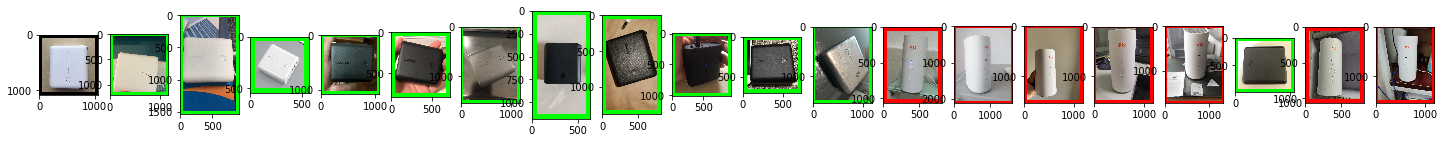

Not found images of the same class
3
1.0 1.0


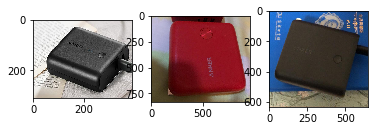

In [62]:
TOPK = 20
# Get distance matrix of shape (query_length x 1000)
distances, perm_matrix = knn.search(query_embeddings, topk=TOPK)

## Validation
def show_prediction(idx):
    query_file = query_files[idx]
    indexes = perm_matrix[idx]
    label = query_labels[idx]
    num_images = len(gallery_labels[gallery_labels == label])
    num_val_images = len(query_labels[query_labels == label])
    dist = distances[idx]
    gallery_file = gallery_files[indexes]
    gallery_label = gallery_labels[indexes]
    
    query = cv2.imread(query_file)
    query = cv2.cvtColor(query, cv2.COLOR_BGR2RGB)
    print(num_images, num_val_images)
    print(dist)
    print(label, gallery_label)
    plt.figure(figsize=(25,25))
    plt.subplot(1, TOPK, 1)
    query = cv2.copyMakeBorder(query, 50, 50, 50, 50, cv2.BORDER_CONSTANT, value=1) 
    plt.imshow(query)
    for i in range(1, TOPK):
        image = cv2.imread(gallery_file[i-1])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if gallery_label[i-1] == label:
            image = cv2.copyMakeBorder(image, 50, 50, 50, 50, cv2.BORDER_CONSTANT, value=[0, 255, 0]) 
        else:
            image = cv2.copyMakeBorder(image, 50, 50, 50, 50, cv2.BORDER_CONSTANT, value=[255, 0, 0]) 
            
        plt.subplot(1, TOPK, i + 1)
        plt.imshow(image)
    plt.show()
        
    print("Not found images of the same class")
    all_relevant_files = df_val[(df_val.is_query == False) & (df_val.label == label)]['full_path']
    
    not_found = []
    for path in all_relevant_files:
        if path not in list(gallery_file):
            not_found.append(path)
    print(len(not_found))
    print(map10[idx].item(), mapR[idx].item())
#     all_images = 
    for i in range(min(10, len(not_found))): # don't draw all
        image = cv2.imread(not_found[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(1, len(not_found), i + 1)
        plt.imshow(image)

show_prediction(131)

# Test

In [27]:
# Best model genet_normal_384_hard_arcface80_15

# Init
config_path = pathlib.Path("logs/genet_normal_384_hard_arcface80_15/")

data = np.load(config_path / "test_B_embeddings.npy",  allow_pickle=True)
test_embeddings = torch.tensor(data.item()["embeddings"])
indexes = data.item()["indexes"]

df_test = pd.read_csv(os.path.join("data/interim", "test_B.csv")).iloc[indexes]
query_mask = df_test["is_query"].values.astype(np.bool)
## !! Originally here was `file_path`
# query_files, gallery_files = df_test["file_path"].values[query_mask], df_test["file_path"].values[~query_mask]
query_files, gallery_files = df_test["full_path"].values[query_mask], df_test["full_path"].values[~query_mask]

# Shape (n_embeddings, embedding_dim)
query_embeddings, gallery_embeddings = test_embeddings[query_mask], test_embeddings[~query_mask]
query_files, gallery_files = df_test["full_path"].values[query_mask], df_test["full_path"].values[~query_mask]
logger.info(f"Test query size - {len(query_embeddings)}, gallery size - {len(gallery_embeddings)}")
del test_embeddings

2020-09-29 19:50:59.365 | INFO     | __main__:<module>:19 - Test query size - 41574, gallery size - 95120


In [11]:
df_test.head()

,file_path,full_path,original_size,aspect_ratio,is_query
0,gallery/014C23YTI5QZ9WAM.jpg,data/interim/test_data_B_512/gallery/014C23YTI...,"(88, 107)",0.8224,0.0
30,gallery/01ITOCW53VRQJKZ2.jpg,data/interim/test_data_B_512/gallery/01ITOCW53...,"(1134, 1301)",0.8716,0.0
34,gallery/01KOZRB37PT2LNDQ.jpg,data/interim/test_data_B_512/gallery/01KOZRB37...,"(599, 721)",0.8308,0.0
52,gallery/01RDQPAUY468BFL2.jpg,data/interim/test_data_B_512/gallery/01RDQPAUY...,"(665, 850)",0.7824,0.0
86,gallery/026UN8Y7XG4SEOLD.jpg,data/interim/test_data_B_512/gallery/026UN8Y7X...,"(549, 631)",0.8700,0.0


In [ ]:
dba = True
aqe = True
num_iter = 1

if dba:
    for _ in range(num_iter):
        gallery_embeddings = query_expansion(gallery_embeddings, gallery_embeddings, topk=5, alpha=3)

if aqe:
    for _ in range(num_iter):
        query_embeddings = query_expansion(query_embeddings, gallery_embeddings, topk=2, alpha=3)

# Init kNN and find neighbours
knn = kNN(embeddings=gallery_embeddings, distance='cosine')
# Get distance matrix of shape (query_length x 100)

In [35]:
distances, perm_matrix = knn.search(query_embeddings, topk=100)

In [36]:
distances.shape

torch.Size([41574, 100])

In [82]:
perm_matrix[:2, :10].shape

gallery_files[perm_matrix[:2, :10]]

(2, 10)

data/raw/test_data_B/query/09PEU6HMF25TJNA4.jpg
tensor([0.5899, 0.5850, 0.4686, 0.4442, 0.4379, 0.4298, 0.4248, 0.4154, 0.4068,
        0.4030, 0.3973, 0.3844, 0.3814, 0.3798, 0.3733, 0.3726, 0.3691, 0.3671,
        0.3635, 0.3627, 0.3609, 0.3549, 0.3534, 0.3498, 0.3479, 0.3421, 0.3368,
        0.3271, 0.3254, 0.3231, 0.3202, 0.3100, 0.3100, 0.3050, 0.3035, 0.3022,
        0.3015, 0.3010, 0.2992, 0.2981, 0.2924, 0.2911, 0.2859, 0.2857, 0.2856,
        0.2849, 0.2848, 0.2828, 0.2811, 0.2803, 0.2769, 0.2758, 0.2750, 0.2734,
        0.2732, 0.2710, 0.2710, 0.2705, 0.2684, 0.2680, 0.2679, 0.2678, 0.2674,
        0.2671, 0.2667, 0.2661, 0.2659, 0.2642, 0.2632, 0.2629, 0.2626, 0.2618,
        0.2611, 0.2610, 0.2605, 0.2591, 0.2585, 0.2585, 0.2582, 0.2581, 0.2577,
        0.2573, 0.2567, 0.2567, 0.2561, 0.2556, 0.2553, 0.2549, 0.2548, 0.2541,
        0.2540, 0.2532, 0.2530, 0.2530, 0.2516, 0.2515, 0.2509, 0.2504, 0.2503,
        0.2501])


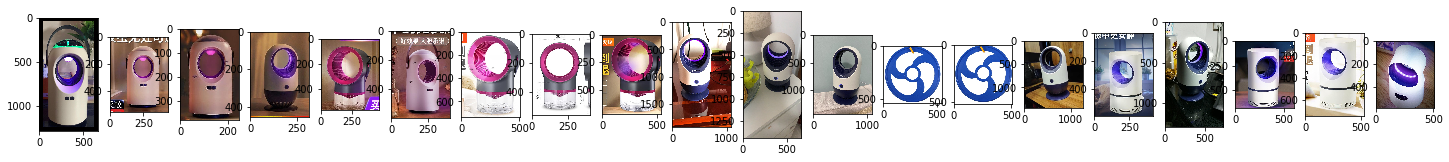

In [119]:
TOPK = 20

def show_prediction_test(idx):
    query_file = query_files[idx]
    indexes = perm_matrix[idx]
    dist = distances[idx]
    gallery_file = gallery_files[indexes]
    
    print(query_file) # gallery_file
    query = cv2.imread(query_file)
    query = cv2.cvtColor(query, cv2.COLOR_BGR2RGB)
    print(dist)
    plt.figure(figsize=(25,25))
    plt.subplot(1, TOPK, 1)
    query = cv2.copyMakeBorder(query, 50, 50, 50, 50, cv2.BORDER_CONSTANT, value=1) 
    plt.imshow(query)
    for i in range(1, TOPK):
        image = cv2.imread(gallery_file[i-1])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)            
        plt.subplot(1, TOPK, i + 1)
        plt.imshow(image)
    plt.show()

# 315, 329
# data/raw/test_data_B/query/0AZH9X7GCV1WMDE2.jpg
#     6  [ 25,  18,   7,   5,  25,   4,   7,   7,   6,   8],

#      9  [  6,  23,  44,  44,   6,  10,  10,   7,  33,  28],
show_prediction_test(6)

In [20]:
import cv2
# import cv2.xfeatures2d as cv
import numpy
from time import time
import pydegensac
from matplotlib import pyplot as plt
from copy import deepcopy

In [21]:
import multiprocessing

In [22]:
list(range(10, 0, -1))

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [22]:
NUM_THREADS = 5

In [24]:
sorted(zip(query_files[:10].flat, gallery_files[:10].flat, range(10, 0, -1)), key=lambda x: (x[0], x[1]))

[('data/interim/test_data_B_512/query/04O36K1EVABPTQF7.jpg',
  'data/interim/test_data_B_512/gallery/014C23YTI5QZ9WAM.jpg',
  10),
 ('data/interim/test_data_B_512/query/05KTPHIDM4SCLU8O.jpg',
  'data/interim/test_data_B_512/gallery/01ITOCW53VRQJKZ2.jpg',
  9),
 ('data/interim/test_data_B_512/query/06PC4NDUG1I78L3W.jpg',
  'data/interim/test_data_B_512/gallery/01KOZRB37PT2LNDQ.jpg',
  8),
 ('data/interim/test_data_B_512/query/0951SEM26AY3TJON.jpg',
  'data/interim/test_data_B_512/gallery/01RDQPAUY468BFL2.jpg',
  7),
 ('data/interim/test_data_B_512/query/09B7GV2DPMI4JYHL.jpg',
  'data/interim/test_data_B_512/gallery/026UN8Y7XG4SEOLD.jpg',
  6),
 ('data/interim/test_data_B_512/query/09MGVKY2N6WTFPE5.jpg',
  'data/interim/test_data_B_512/gallery/02D9H3TJO18GWY76.jpg',
  5),
 ('data/interim/test_data_B_512/query/09PEU6HMF25TJNA4.jpg',
  'data/interim/test_data_B_512/gallery/02GQWIFBNRH6MTDE.jpg',
  4),
 ('data/interim/test_data_B_512/query/09Q4L1GKXR53EOZI.jpg',
  'data/interim/test_data_B_

In [23]:
def rerank(query_files, gallery_files, perm_matrix, topk=10, limit=15):
    perm_matrix = np.array(perm_matrix)[:, :topk]
    query_files = query_files.reshape(-1, 1).repeat(topk, axis=1)
    gallery_files = gallery_files[perm_matrix]
    files = list(zip(query_files.flat, gallery_files.flat))
    
    with multiprocessing.Pool(NUM_THREADS) as pool:
        # Shape (num_queries, topk)
        inliers = list(tqdm(pool.starmap(count_inliers, files), total=len(files)))
        
    # Count number of columns for each row where sum(inliers > limit) > 10
    # Then just take all columns with inliers and finish with that
    # Otherwise place all such cases on top and add rest sorted 
    inliers = sorted(inliers, key=lambda x: )
    mask = np.array(inliers).reshape(-1, topk) > limit
    reranked_matrix = []
    for i in tqdm(range(len(query_files))):
        top = perm_matrix[i][mask[i]]
        bottom = perm_matrix[i][~mask[i]][: topk - len(top)]

        reranked_matrix.append(list(top) + list(bottom))

    reranked_matrix = np.array(reranked_matrix)
    print(reranked_matrix.shape)
    print(mask)
    return reranked_matrix

In [200]:
topk=15
rerank_ = rerank(query_files[:20], gallery_files, perm_matrix[:20], topk=topk, limit=10)
# [1 0 0 1 0 0 3 0 3 6 1 1 0 3 0 0 1 0 3 1 5 3 0 4 1 3 0 3 1 3 0 0 6 0 0 0 0 8 9 0]
# [1 0 0 0 0 1 3 0 3 6 1 0 2 5 0 0 0 2 5 1 7 9 1 2 1 3 0 12 2 4 0 1 7 0 0 0 0 15 9 0]
# [ 0  0  0  1  0  0  2  0  3  5  1  0  0  3  0  0  0  2  4  1  4  5  0  3 0  3  0  7  0  0  0  0  5  0  0  0  0 14  9  0]

100%|██████████| 20/20 [00:00<00:00, 34113.90it/s]

(20, 15)
[[False False False False  True False False False  True False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [ True False False False  True False False False False False False False
  False False False]
 [False False False False False False False False False False False False
  False False False]
 [ True  True False False False False False False False False False False
  False False False]
 [ True  True False False  True False False False False False False False
  False False False]
 [False False  True False  True False False False  True False False False
  False False False]
 [ True  True  True False False False False False False False False False
  False False False]
 [ True  True False  True False False False  True  True  True  True False
  False False False]
 [False  True False False False False Fal

In [202]:
perm_matrix[0][:topk]

tensor([94564, 11513, 31971, 56067, 91407, 62697, 56089, 50694, 25373, 22260,
        80297, 69800, 72168, 84863, 12059])

In [204]:
result[0]

array([91407, 25373, 94564, 11513, 31971, 56067, 62697, 56089, 50694,
       22260, 80297, 69800, 72168, 84863, 12059])

In [25]:
def count_inliers(img1_path, img2_path, th = 4.0, n_iter = 2000):
    img1 = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2RGB)

#     # SIFT is not available by pip install, so lets use AKAZE features
#     det = cv2.AKAZE_create(descriptor_type = 3, threshold=0.00001)
#     kps1, descs1 = det.detectAndCompute(img1,None)
#     kps2, descs2 = det.detectAndCompute(img2,None)
    
#     # BFMatcher with default params
#     bf = cv2.BFMatcher(crossCheck=True)
#     tentatives = bf.match(descs1,descs2)
#     matches = bf.knnMatch(descs1,descs2, k=2)

    # Need to draw only good matches, so create a mask
#     matchesMask = [False for i in range(len(matches))]

    # SNN ratio test
#     for i,(m,n) in enumerate(matches):
#         if m.distance < 0.9*n.distance:
#             matchesMask[i]=True
#     tentatives = [m[0] for i, m in enumerate(matches) if matchesMask[i] ]

    det = cv2.ORB_create(1000, WTA_K=2)    
    kps1, descs1 = det.detectAndCompute(img1,None)
    kps2, descs2 = det.detectAndCompute(img2,None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) # if WTA_K = 2
#     bf = cv2.BFMatcher(cv2.NORM_HAMMING2, crossCheck=True)
    if descs1 is None or descs2 is None:
        # No matches if one of the image doesn't have keypoint
        return (img1_path, img2_path, 0)
    tentatives = bf.match(descs1,descs2)
    
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    try:
        _, mask = pydegensac.findHomography(src_pts, dst_pts, th, 0.99, n_iter)
    except:
        print(descs1.shape, "\n", descs2.shape, "\n", src_pts.shape, dst_pts.shape)
        return (img1_path, img2_path, 0)
    return (img1_path, img2_path, mask.sum())

# img1 = "data/raw/test_data_B/query/0OWZNAL8IRX5PES1.jpg"
                                                 
# img2 = "data/raw/test_data_B/gallery/3VUB0E98COZSL7IM.jpg" # correct 

In [76]:
count_inliers(img1, img2)

34.7 ms ± 484 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
    # SIFT is not available by pip install, so lets use AKAZE features
    det = cv2.AKAZE_create(descriptor_type = 3, threshold=0.00001)
    kps1, descs1 = det.detectAndCompute(img1,None)
    kps2, descs2 = det.detectAndCompute(img2,None)

    # AKAZE features output "detection" scale, which is 6x less than one used for descriptor
    # For correct drawing, we increase it manually
    for i in range(len(kps1)):
        kps1[i].size = 5*kps1[i].size
    for i in range(len(kps2)):
        kps2[i].size = 5*kps2[i].size
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descs1,descs2, k=2)

    # Need to draw only good matches, so create a mask
    matchesMask = [False for i in range(len(matches))]

    # SNN ratio test
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.9*n.distance:
            matchesMask[i]=True
    tentatives = [m[0] for i, m in enumerate(matches) if matchesMask[i] ]

# Extract train embeddings, split on query / gallery and compute metrics

In [39]:
from loguru import logger
import albumentations.pytorch as albu_pt
class Dataset(torch.utils.data.Dataset):
    _aspect_ratios = np.array([2, 16 / 9, 3 / 2, 4 / 3, 5 / 4, 1, 4 / 5, 3 / 4, 2 / 3, 9 / 16, 1 / 2])

    def __init__(self, root="data/interim", transform=None, train=None, size=512):
        df = pd.read_csv(os.path.join(root, "train_val.csv"))
        
        if train is not None:
            df = df[df["is_train"].astype(np.bool) == train]
    
        self.filenames = [
            os.path.join(root, f"train_data_{size}", path) for path in df["file_path"].values.tolist()]

        # Сheck that all images exist
        assert map(lambda x: pathlib.Path(x).exists(), self.filenames), "Found missing images!"

        self.targets = df["label"].values.tolist()
        self.ar = df["aspect_ratio"].values

        # For each aspect ration in `ar` find closest value from the
        # `_aspect_ratios` and return it's index (group)
        self.group_ids = np.argmin(
            np.abs(self._aspect_ratios.reshape(1, -1) - self.ar.reshape(-1, 1)),
            axis=1
        )

        self.sizes = []
        for group in self.group_ids:
            ar = self._aspect_ratios[group]
            # Resize image to have `size` shape on smaller side and be devidable by 16 on another
            if ar <= 1:
                H = size
                W = int(size / ar) // 8 * 8
            else:
                W = size
                H = int(size * ar) // 8 * 8
            self.sizes.append((H, W))

        logger.info(f"Using sizes {set(self.sizes)} for {'train'if train else 'validation'}")
        self.transform = albu.Compose([albu_pt.ToTensorV2()]) if transform is None else transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        # logger.info(f"Index {index}")
        image = cv2.imread(self.filenames[index], cv2.IMREAD_COLOR)
        # logger.info(f"{index} Size before reshape {image.shape}")
        image = cv2.resize(image, self.sizes[index])
        # logger.info(f"{index} Size after reshape {image.shape}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image=image)["image"]

        target = self.targets[index]

        return image, target

    def __len__(self):
        return len(self.filenames)

from src.augmentations import get_aug
from src.utils import ToCudaLoader
from src.datasets import GroupedBatchSampler

aug = get_aug('val', size=512)
BATCH_SIZE = 32

dataset = Dataset(root="data/interim", transform=aug, train=None, size=512)

gb_sampler = GroupedBatchSampler(
    sampler=torch.utils.data.sampler.SequentialSampler(dataset),
    group_ids=dataset.group_ids,
    batch_size=BATCH_SIZE,
    drop_uneven=False,
)

loader = torch.utils.data.DataLoader(
    dataset,
    num_workers=8,
    pin_memory=False,
    batch_sampler=gb_sampler,
)

loader = ToCudaLoader(loader)
logger.info(f"Len dataset {len(dataset)}")

# GB sampler changes the order of images depending on batch size
indexes = [idx for batch in list(gb_sampler) for idx in batch]



from predict import predict_from_loader
from src.models import Model
import pathlib

# Get model
model = Model(
    arch="genet_normal",
    model_params={},
    embedding_size=512,
    pooling="gem").cuda()
# logger.info(model)

# Init
checkpoint = torch.load(pathlib.Path("logs/genet_normal_384_hard_arcface80_15") / f"model.chpn")
model.load_state_dict(checkpoint["state_dict"], strict=False)

2020-09-25 21:33:36.929 | INFO     | __main__:__init__:40 - Using sizes {(768, 512), (512, 512), (640, 512), (512, 1024), (512, 768), (1024, 512), (512, 640), (680, 512), (904, 512), (512, 904), (512, 680)} for validation
2020-09-25 21:33:36.937 | INFO     | __main__:<module>:89 - Len dataset 68601


<All keys matched successfully>

In [40]:
model.model.adptive_avg_pool.netblock.p = torch.tensor(4.0)

In [41]:
embeddings = predict_from_loader(model, loader)

100%|██████████| 2150/2150 [08:52<00:00,  4.04it/s]


In [97]:
# Randomly split TRAIN data into query / gallery and compute metrics
df = pd.read_csv(os.path.join("data/interim", "train_val.csv")).iloc[indexes]
labels = df["label"].values

train_mask = df["is_train"].values.astype(np.bool)
train_embeddings = embeddings[train_mask]
train_labels = labels[train_mask]

query_mask = torch.FloatTensor(len(train_embeddings)).uniform_() < 0.25

query_embeddings, gallery_embeddings = train_embeddings[query_mask], train_embeddings[~query_mask]
query_labels, gallery_labels = train_labels[query_mask], train_labels[~query_mask]
logger.info(f"Train query size - {len(query_embeddings)}, gallery size - {len(gallery_embeddings)}")

# Shape (query_size x gallery_size)
conformity_matrix = torch.tensor(query_labels.reshape(-1, 1) == gallery_labels)

# Init kNN and find neighbours
knn = kNN(embeddings=gallery_embeddings, distance='cosine')
# Get distance matrix of shape (query_length x 1000)
distances, perm_matrix = knn.search(query_embeddings, topk=1000)

# Compute validation metrics
acc1 = accuracy_at_1(perm_matrix, conformity_matrix)
map10 = map_at_k(perm_matrix, conformity_matrix, topk=10)
mapR = map_at_k(perm_matrix, conformity_matrix, topk=None)

logger.info(
    f"Train: Acc@1 {acc1:0.5f}, mAP@10 {map10:0.5f}, Target {0.5 * acc1 + 0.5 * map10:0.5f}, mAP@R {mapR:0.5f}")

2020-09-27 03:20:44.056 | INFO     | __main__:<module>:13 - Train query size - 11354, gallery size - 33576
2020-09-27 03:20:49.733 | INFO     | __main__:<module>:29 - Train: Acc@1 0.96944, mAP@10 0.97051, Target 0.96998, mAP@R 0.96979


In [43]:
# Load validation query / gallery split and sort it according to indexes from sampler
df = pd.read_csv(os.path.join("data/interim", "train_val.csv")).iloc[indexes]

query_mask = df["is_query"].values.astype(np.bool)
labels = df["label"].values

# Shape (n_embeddings, embedding_dim)
query_embeddings, gallery_embeddings = embeddings[query_mask], embeddings[~query_mask]
query_files, gallery_files = df["full_path"].values[query_mask], df["full_path"].values[~query_mask]
query_labels, gallery_labels = labels[query_mask], labels[~query_mask]
logger.info(f"Validation query size - {len(query_embeddings)}, gallery size - {len(gallery_embeddings)}")

# Shape (query_size x gallery_size)
conformity_matrix = torch.tensor(query_labels.reshape(-1, 1) == gallery_labels)

# Init kNN and find neighbours
knn = kNN(embeddings=gallery_embeddings, distance='cosine')
# Get distance matrix of shape (query_length x 1000)
distances, perm_matrix = knn.search(query_embeddings, topk=1000)

# Compute validation metrics
acc1 = accuracy_at_1(perm_matrix, conformity_matrix)
map10 = map_at_k(perm_matrix, conformity_matrix, topk=10)
mapR = map_at_k(perm_matrix, conformity_matrix, topk=None)

logger.info(
    f"Val + Train: Acc@1 {acc1:0.5f}, mAP@10 {map10:0.5f}, Target {0.5 * acc1 + 0.5 * map10:0.5f}, mAP@R {mapR:0.5f}")

2020-09-25 21:42:59.624 | INFO     | __main__:<module>:11 - Validation query size - 1702, gallery size - 66899
2020-09-25 21:43:03.700 | INFO     | __main__:<module>:27 - Val + Train: Acc@1 0.93478, mAP@10 0.92618, Target 0.93048, mAP@R 0.91228


2020-09-25 20:15:56.277 | INFO     | __main__:<module>:15 - Val + Train: Acc@1 0.93537, mAP@10 0.92639, Target 0.93088, mAP@R 0.91155


In [19]:
# query_embeddings, gallery_embeddings = ...
# kd - how many nearest neighbours for each image to search. Rename -> max_neighbours?
kd = 50
kq = 10
gamma = 3
truncation_size = 1000 # 5000? authors say it improves results for bigger datasets